In [11]:
import argparse, random
from typing import List, Dict
import torch, numpy as np, pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [12]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [13]:
def sample_pairs(ds_split, num_pairs: int, label: int = 1) -> List[Dict]:
    """
    Args:
        ds_split: Hugging Face dataset split (e.g., train/test/validation).
        num_pairs: Number of pairs to sample.
        label: Which pairs to sample (1 = clones, 0 = non-clones).

    Returns:
        A list of dictionaries, each containing:
          - code1: str, first code snippet
          - code2: str, second code snippet
          - label: int, pair label (0/1)
          - idx: int, index of the pair in the sampled set
    """

    # Collect all candidates with normalized labels
    candidates = []
    for ex in ds_split:
        ex_label = 1 if ex["label"] else 0   # normalize boolean → int
        if ex_label == label:
            # store normalized label inside entry for later reuse
            ex["_norm_label"] = ex_label
            candidates.append(ex)

    # Check if we have enough samples
    if len(candidates) < num_pairs:
        raise ValueError(
            f"Requested {num_pairs} pairs with label={label}, "
            f"but only found {len(candidates)}."
        )

    # Shuffle for randomness
    random.shuffle(candidates)

    # Select N pairs
    out = []
    for i, ex in enumerate(candidates[:num_pairs]):
        pair_dict = {
            "code1": ex["func1"],
            "code2": ex["func2"],
            "label": ex["_norm_label"],  # reuse normalized value
            "idx": i,
        }
        out.append(pair_dict)

    return out

In [14]:
def sample_mixed(ds_split, num_pairs: int, seed: int = 42) -> List[Dict]:
    """
    Randomly sample code pairs (clones and non-clones) from the dataset,
    following the dataset's natural distribution. Uses a fixed seed for
    reproducibility.

    Args:
        ds_split: Hugging Face dataset split (e.g., train/test).
        num_pairs: Total number of pairs to return.
        seed: Random seed for reproducibility.

    Returns:
        A list of dictionaries, each with:
          - code1: str, first code snippet
          - code2: str, second code snippet
          - label: int, pair label (1 = clone, 0 = non-clone)
          - idx:   int, index of this pair in the final list
    """
    set_seed(seed)

    # Shuffle dataset entries
    candidates = list(ds_split)
    random.shuffle(candidates)

    # Take the first N pairs
    out = []
    for i, ex in enumerate(candidates[:num_pairs]):
        label = 1 if ex["label"] else 0
        pair_dict = {
            "code1": ex["func1"],
            "code2": ex["func2"],
            "label": label,
            "idx": i,
        }
        out.append(pair_dict)

    return out

In [15]:
@torch.no_grad()
def embed_code(
    snippets: List[str],
    tokenizer,
    model,
    max_length: int = 256,
    device: str = "cpu",
    batch_size: int = 8
) -> np.ndarray:
    """
    Embed code snippets using CodeBERT (batched version).

    Args:
        snippets: List of code strings.
        tokenizer: Hugging Face tokenizer (e.g., CodeBERT tokenizer).
        model: Hugging Face transformer model (e.g., CodeBERT model).
        max_length: Max tokens per snippet (truncates longer code).
        device: "cpu" or "cuda".
        batch_size: Number of snippets per batch.

    Returns:
        NumPy array of shape (N, H) where:
          N = number of snippets,
          H = hidden size of the model (768 for CodeBERT-base).
    """
    all_vecs = []

    for i in range(0, len(snippets), batch_size):
        batch = snippets[i:i + batch_size]

        # Tokenize a batch of snippets
        enc = tokenizer(
            batch,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        # Forward pass through model
        out = model(**enc)

        # Extract CLS embeddings for the whole batch
        cls_vecs = out.last_hidden_state[:, 0, :]   # shape (batch_size, hidden_dim)

        # Move to CPU + convert to NumPy
        all_vecs.append(cls_vecs.cpu().numpy())

    # Concatenate all batches into one matrix
    return np.vstack(all_vecs)

Loading dataset
Sampling 5 pairs
Loading model on cpu...
Embedding code snippets.
Running t-SNE
Saved embeddings.csv
Plotting Graph
Saved tsne_codebert_pairs.png

=== Similarity diagnostics ===
Avg cosine similarity within pairs: 0.9947 (+/- 0.0031)
Avg cosine similarity across random others: 0.9947 (+/- 0.0011)


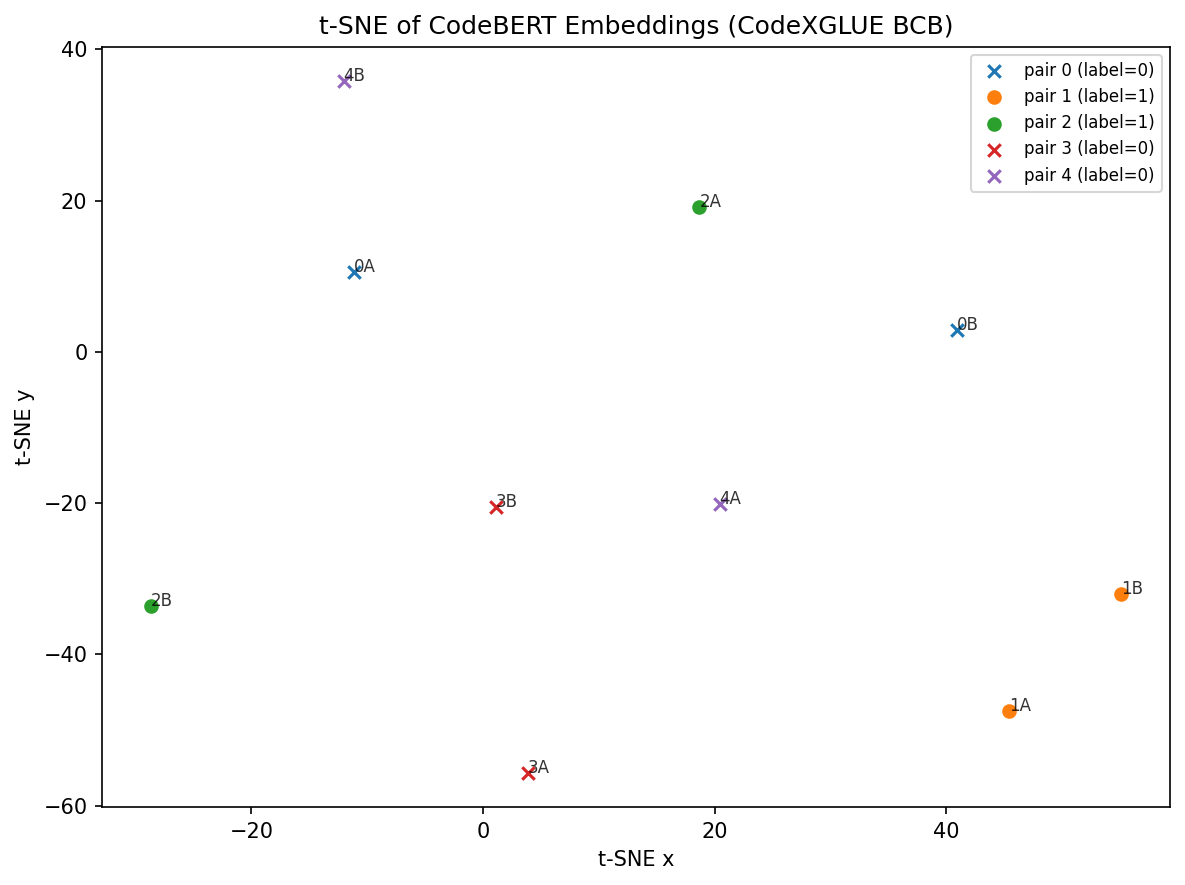

In [16]:
def main():
    p = argparse.ArgumentParser()
    p.add_argument("--split", default="train", choices=["train", "validation", "test"])
    p.add_argument("--label", type=int, default=1, choices=[0, 1])
    p.add_argument("--num_pairs", type=int, default=5)
    p.add_argument("--max_length", type=int, default=256)
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--mix", action="store_true")

    # --- Colab-friendly fix ---
    # Ignore Jupyter's hidden args, and force mix mode ON
    args = p.parse_args(args=[])
    args.mix = True

    set_seed(args.seed)
    print("Loading dataset")
    ds = load_dataset("google/code_x_glue_cc_clone_detection_big_clone_bench")
    split = ds[args.split]

    print(f"Sampling {args.num_pairs} pairs")
    pairs = sample_mixed(split, args.num_pairs)

    rows = []
    for ex in pairs:
        rows += [
            {"pair_idx": ex["idx"], "which": "A", "label": ex["label"], "code": ex["code1"]},
            {"pair_idx": ex["idx"], "which": "B", "label": ex["label"], "code": ex["code2"]},
        ]
    df = pd.DataFrame(rows)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading model on {device}...")
    tok = AutoTokenizer.from_pretrained("microsoft/codebert-base")
    mdl = AutoModel.from_pretrained("microsoft/codebert-base").to(device); mdl.eval()

    print("Embedding code snippets.")
    X = embed_code(df["code"].tolist(), tok, mdl, max_length=args.max_length, device=device)
    df_emb = pd.DataFrame(X)
    df_all = pd.concat([df.reset_index(drop=True), df_emb], axis=1)

    print("Running t-SNE")
    tsne = TSNE(n_components=2, perplexity=5, random_state=args.seed, init="random", learning_rate="auto")
    coords = tsne.fit_transform(X)
    df_all["tsne_x"], df_all["tsne_y"] = coords[:,0], coords[:,1]
    df_all.to_csv("embeddings.csv", index=False)
    print("Saved embeddings.csv")

    print("Plotting Graph")
    plt.figure(figsize=(8,6), dpi=150)
    pair_ids = sorted(df_all["pair_idx"].unique())
    markers = {0:"x", 1:"o"}
    for pid in pair_ids:
        sub = df_all[df_all["pair_idx"] == pid]
        m = markers[int(sub["label"].iloc[0])]
        plt.scatter(sub["tsne_x"], sub["tsne_y"], label=f"pair {pid} (label={int(sub['label'].iloc[0])})", marker=m)
        for _, r in sub.iterrows():
            plt.annotate(f"{pid}{r['which']}", (r["tsne_x"], r["tsne_y"]), fontsize=8, alpha=0.8)
    plt.title("t-SNE of CodeBERT Embeddings (CodeXGLUE BCB)")
    plt.xlabel("t-SNE x"); plt.ylabel("t-SNE y"); plt.legend(loc="best", fontsize=8); plt.tight_layout()
    plt.savefig("tsne_codebert_pairs.png")
    print("Saved tsne_codebert_pairs.png")

    print("\n=== Similarity diagnostics ===")
    sims = cosine_similarity(X)
    within, across = [], []
    for pid in pair_ids:
        idxs = df_all.index[df_all["pair_idx"] == pid].tolist()
        if len(idxs) == 2:
            within.append(sims[idxs[0], idxs[1]])
        others = [j for j in range(len(df_all)) if j not in idxs]
        if others:
            sel = random.sample(others, min(3, len(others)))
            across.append(float(np.mean([sims[idxs[0], j] for j in sel])))
    if within:
        print(f"Avg cosine similarity within pairs: {float(np.mean(within)):.4f} (+/- {float(np.std(within)):.4f})")
    if across:
        print(f"Avg cosine similarity across random others: {float(np.mean(across)):.4f} (+/- {float(np.std(across)):.4f})")

if __name__ == "__main__":
    main()
